In [5]:

#import libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import spacy
from sklearn.decomposition import PCA
import torch
from transformers import BertTokenizer, BertModel
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


head = pd.read_csv("data1final.csv")
head = head.iloc[:,[1,2,3,4]]
head = head[head['date']>'2023-02-08']
head.drop(head.tail(177).index,inplace=True)
# Download and load BERT model and tokenizer
#tokenizer breaks down comments in meaninful tokens
#Bert pretrained on bert absed uncased, very wide pool of phrases, source include wikepedia
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
head = head[head['comments'].str.split().str.len() >= 8]
def bert_embedding(comment):
    # Tokenize the comment and convert to input IDs
    inputs = tokenizer(comment, return_tensors='pt', padding=True, truncation=True)
    #padding = add extra tokens to to make all input sequence to make it equal to the ther
    #truncation = cut off tokens from input if the exceed a threshold
    
    # Generate BERT embeddings
    with torch.no_grad():
        outputs = model(**inputs)#call the pretrained model
        embeddings = outputs[0][0]  # Use the first (and only) sequence in the batch
    
    # Convert the embeddings to a numpy array
    embeddings = embeddings.numpy()
    
    return embeddings

c:\Users\User\anaconda3\envs\finec\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly iden

In [6]:
#we get the avg of the embeddings scores
def avg_emb(embeddings) :
  return sum(embeddings) / len(embeddings)

In [7]:
def emb_bert(comments):
# Tokenize the text
#tokens cannot be more than 512 to be analyzed by the encoder
  tokens = tokenizer.encode(comments, add_special_tokens=True, truncation=True, max_length=512)
  if len(tokens) > 512:
    tokens = tokens[:512-1] + [tokens[-1]]  # Truncate tokens and keep the last token

  return tokens

In [8]:
#Transform in tensor
def outp(tensor):
  
  input_ids = torch.tensor(tensor).unsqueeze(0)
  return input_ids

In [9]:
#split to make it run
split_index = len(head) // 300
sentiment = []

#run all the functions and get the sentiment score

for i in range(300):
    head1 = head.iloc[i * split_index:(i + 1) * split_index].copy()  # Make a copy of the DataFrame
    head1.loc[:, 'bert_embeddings'] = head1['comments'].apply(bert_embedding)  # Use .loc to modify the original DataFrame
    head1["mean_emb"] = head1["bert_embeddings"].apply(lambda x: avg_emb(x))
    head1["tensor"] = head1["comments"].apply(lambda x: emb_bert(x))
    head1["input_ids"] = head1["tensor"].apply(lambda x: outp(x))
    head1["outputs"] = head1["input_ids"].apply(lambda x: model(x))
    head1["pooled"] = head1["outputs"].apply(lambda x: x.pooler_output.detach().cpu().numpy())
    head1['sent'] = head1.apply(lambda x: (x["mean_emb"].dot(x["pooled"].T)/(np.linalg.norm(x["mean_emb"])*np.linalg.norm(x["pooled"]))).item(), axis=1)
    sentiment.append(list(head1['sent']))
    print(i)
    #pooled to detach from tensor, poass the vectors to cpu and treat them like numpy array

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [10]:
len(sentiment)
copy= sentiment.copy()

In [11]:
final=[]
for i in range(len(sentiment)):
  final=final+sentiment[i]
len(final)

11400

In [16]:
#save in a file
file_name='nn.csv'
path = 'C:/Users/User/Documents/EPFL/fineconom/conda'
head['sentiment']=final
head = head.loc[:,['sentiment','comments','date','sector','name']]
head.to_csv(file_name,index=False)

Summary statistics and general analysis

In [19]:
#summary statistics
df = pd.read_csv("nn.csv")
summary_stats = df['sentiment'].describe()
print(summary_stats)


count    11400.000000
mean         0.001182
std          0.017838
min         -0.059625
25%         -0.010450
50%          0.001559
75%          0.013485
max          0.053073
Name: sentiment, dtype: float64


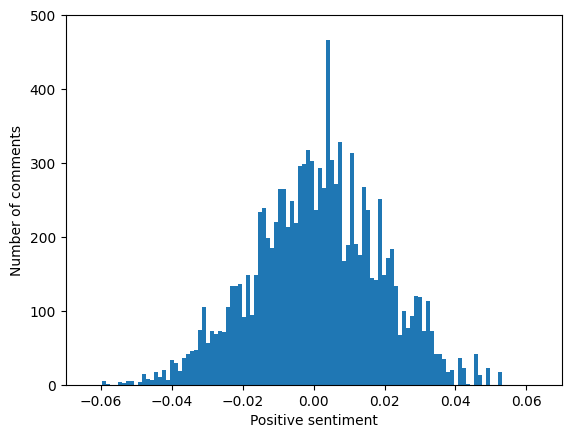

In [20]:
plt.hist(df.sentiment,bins=100)
plt.xlim([-0.07,0.07])
plt.ylim([0,500])
plt.xlabel('Positive sentiment')
plt.ylabel('Number of comments')
plt.show()

In [21]:
#make the column comparable with vader: distribution -1,1
min_val= np.min(df.sentiment)
max_val = np.max(df.sentiment)
df["normalized_value"] = df["sentiment"].apply(lambda x:2 * (x - min_val) / (max_val - min_val) - 1) 


In [24]:
summary_stats_norm = df['normalized_value'].describe()
print(summary_stats_norm)

count    11400.000000
mean         0.079118
std          0.316557
min         -1.000000
25%         -0.127320
50%          0.085809
75%          0.297446
max          1.000000
Name: normalized_value, dtype: float64


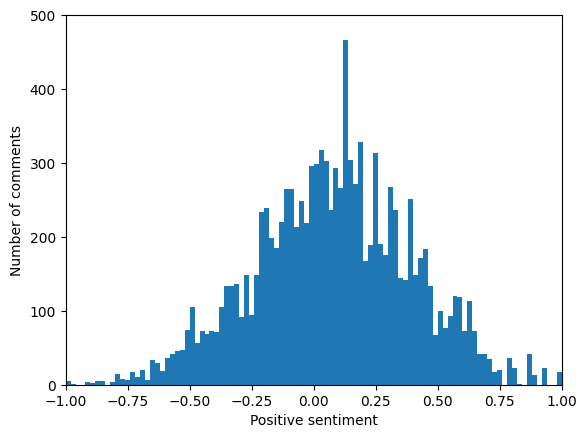

In [23]:
plt.hist(df["normalized_value"],bins=100)
plt.xlim([-1,1])
plt.ylim([0,500])
plt.xlabel('Positive sentiment')
plt.ylabel('Number of comments')
plt.show()